In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv, pd.read_parquet )
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter

import os, gc
from tqdm.auto import tqdm
import pickle # module to serialize and deserialize objects
import re # for Regular expression operations 

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data  import Dataset, DataLoader
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer)
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Timer

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

import kaggle_evaluation.jane_street_inference_server
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jane-street-real-time-market-data-forecasting/responders.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/sample_submission.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/features.csv
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=4/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=5/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=6/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=3/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=1/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=8/part-0.parquet
/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=2/part-0.parquet
/kaggle/input/jane-street-real-time-market

In [4]:
%%time
path = "/kaggle/input/jane-street-real-time-market-data-forecasting"
samples = [] 

r = range(2)
for i in r:
    file_path = f"{path}/train.parquet/partition_id={i}/part-0.parquet"
    part = pd.read_parquet(file_path)
    samples.append(part)
    
sample_df = pd.concat(samples, ignore_index=True) # Concatenate all samples into one DataFrame if needed

sample_df.round(1)

CPU times: user 7.02 s, sys: 12.7 s, total: 19.7 s
Wall time: 12.9 s


,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.9,NaN,NaN,NaN,NaN,NaN,0.9,0.2,0.3,-0.9,11,7,76,-0.9,0.0,-0.7,NaN,-0.2,NaN,-1.3,-1.7,0.9,NaN,1.6,1.5,-1.6,-0.2,NaN,NaN,1.4,-0.3,0.1,NaN,NaN,NaN,0.3,0.3,0.3,-0.0,-0.2,NaN,-1.1,NaN,NaN,-0.2,NaN,NaN,NaN,0.6,2.1,0.8,NaN,0.2,NaN,NaN,-0.8,NaN,-2.0,0.7,NaN,-1.0,-0.3,-1.4,NaN,NaN,NaN,NaN,NaN,-1.3,-0.1,-0.5,-1.0,0.2,-0.7,NaN,NaN,-0.3,-0.2,-0.3,-0.3,0.7,-0.1,1.4,2.0,0.2,1.2,0.8,0.3,0.1
1,0,0,7,1.4,NaN,NaN,NaN,NaN,NaN,0.7,0.2,0.2,-0.5,11,7,76,-0.9,-0.2,-0.6,NaN,0.3,NaN,-1.3,-1.7,1.4,NaN,0.5,0.7,-0.8,0.6,NaN,NaN,0.2,0.6,1.1,NaN,NaN,NaN,-1.5,-1.4,-1.8,-0.1,-0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.8,-0.0,-0.6,NaN,1.2,NaN,NaN,-1.6,NaN,-1.4,1.1,NaN,0.9,0.5,-1.4,NaN,NaN,NaN,NaN,NaN,-1.1,0.0,-0.6,-1.1,-0.4,-0.7,NaN,NaN,-0.3,-0.2,-0.2,-0.3,3.0,1.2,-0.5,3.8,2.6,5.0,0.7,0.2,0.8
2,0,0,9,2.3,NaN,NaN,NaN,NaN,NaN,1.1,0.2,0.2,-0.8,11,7,76,-0.7,-0.2,-0.6,NaN,-0.8,NaN,-1.3,-2.0,0.6,NaN,1.6,0.7,-1.4,0.4,NaN,NaN,-0.0,-0.3,-0.1,NaN,NaN,NaN,-0.3,-1.0,-2.4,0.1,-0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.4,-3.5,-4.7,NaN,0.5,NaN,NaN,-0.7,NaN,-2.3,1.8,NaN,-0.1,-0.1,-1.4,NaN,NaN,NaN,NaN,NaN,-0.9,-0.1,-0.6,-0.9,-0.2,-0.7,NaN,NaN,0.4,0.3,-0.1,-0.1,-0.9,-0.3,-0.3,0.4,1.3,0.1,2.1,0.7,0.8
3,0,0,10,0.7,NaN,NaN,NaN,NaN,NaN,1.1,0.3,0.3,-1.3,42,5,150,-0.7,3.0,0.1,NaN,-0.3,NaN,-1.9,-1.0,0.2,NaN,-0.4,-0.2,-2.1,-0.9,NaN,NaN,0.4,-0.6,0.1,NaN,NaN,NaN,0.5,-0.1,-1.5,-0.2,-0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4,2.7,0.6,NaN,2.4,NaN,NaN,1.3,NaN,-0.8,2.9,NaN,4.0,1.8,-1.4,NaN,NaN,NaN,NaN,NaN,-0.7,1.1,-0.2,-0.5,4.8,0.6,NaN,NaN,-0.2,-0.3,-0.2,-0.3,0.4,0.2,2.3,1.1,1.2,1.2,1.1,0.8,-1.4
4,0,0,14,0.4,NaN,NaN,NaN,NaN,NaN,1.0,0.3,0.3,-0.6,44,3,16,-0.9,-0.0,-0.5,NaN,0.6,NaN,-1.8,-1.6,-0.2,NaN,-1.0,-0.7,-1.3,-1.4,NaN,NaN,0.0,-0.3,-0.0,NaN,NaN,NaN,-0.1,-1.0,-2.6,-0.2,-0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.0,-2.3,-3.7,NaN,1.3,NaN,NaN,0.5,NaN,-0.8,2.8,NaN,1.4,0.4,-1.4,NaN,NaN,NaN,NaN,NaN,-0.9,-0.1,-0.4,-1.1,0.1,-0.7,NaN,NaN,3.7,2.8,2.6,3.4,-0.4,-0.5,-0.3,-3.9,-1.6,-5.0,-3.6,-1.1,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748452,339,848,19,4.4,-0.4,-1.1,-0.4,0.0,-1.2,-0.1,0.5,0.3,-0.2,4,3,11,0.3,1.4,0.2,-0.6,-0.4,-0.7,0.0,4.9,0.6,NaN,0.9,0.3,-0.1,0.5,NaN,NaN,0.4,-0.7,-0.7,NaN,0.2,-0.6,0.4,0.4,-1.0,-1.0,-1.2,0.2,1.3,0.8,1.4,0.2,0.4,1.0,2.0,1.3,2.1,0.9,0.8,1.6,1.3,1.9,1.1,1.6,1.3,2.5,1.7,3.1,1.8,0.6,-0.4,-0.2,-0.5,-0.5,4.2,-0.0,-0.1,-0.3,0.4,4.4,0.7,-0.0,0.1,-0.2,-0.1,-0.2,-0.1,0.2,0.1,1.1,0.5,0.3,0.5,0.0,0.0,0.0
4748453,339,848,30,0.9,0.0,-1.1,-0.3,-0.2,-1.1,-0.1,0.5,0.3,-0.5,81,2,534,0.2,1.2,0.4,0.3,0.3,0.2,1.9,-1.8,-0.6,NaN,-1.3,-1.0,-0.6,-0.6,NaN,NaN,-0.3,0.0,0.2,NaN,0.5,-1.0,0.2,1.1,0.6,2.2,-0.5,2.4,-1.4,-1.4,0.3,-0.6,-0.2,0.3,-0.9,1.4,0.5,0.9,2.0,1.4,0.2,-0.5,-1.3,-0

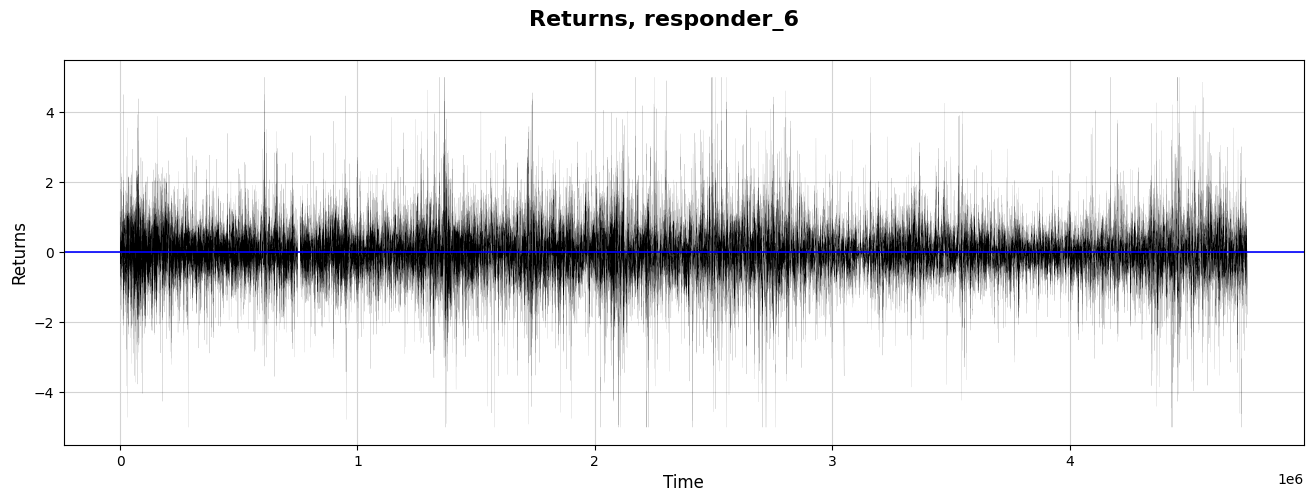

In [5]:
gridColor='lightgrey'
train =sample_df
train['N']=train.index.values 
train['id']=train.index.values 

xx= sample_df[(sample_df.symbol_id==1)] ['id']
yy=sample_df[ (sample_df.symbol_id==1)]['responder_6']

plt.figure(figsize=(16, 5))
plt.plot(xx,yy, color = 'black', linewidth =0.05)
plt.suptitle('Returns, responder_6', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Returns", fontsize=12)
plt.grid(color = gridColor , linewidth=0.8)
plt.axhline(0, color='blue', linestyle='-', linewidth=1.2)
plt.show()


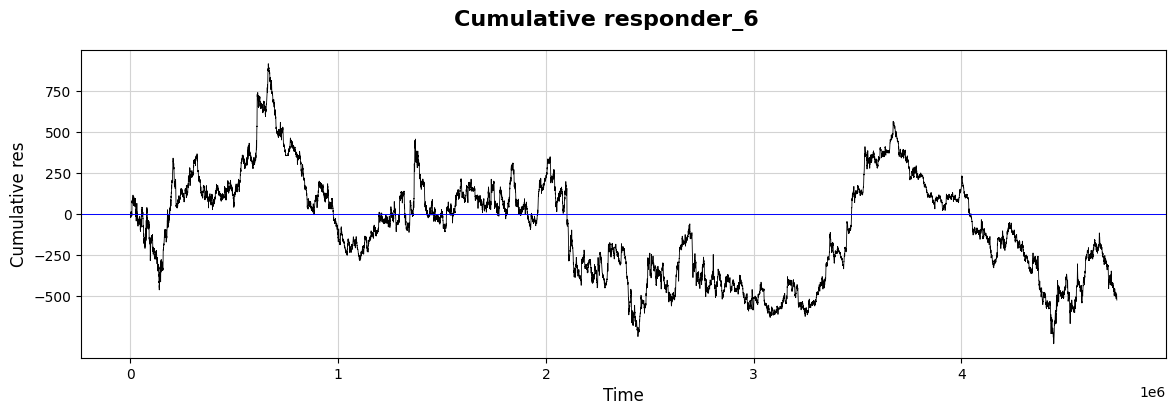

In [6]:
#for symbol_id=1
plt.figure(figsize=(14, 4))
plt.plot(xx,yy.cumsum(), color = 'black', linewidth =0.6)
plt.suptitle('Cumulative responder_6', weight='bold', fontsize=16)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Cumulative res", fontsize=12)
plt.yticks(np.arange(-500,1000,250))
#plt.xticks(np.arange(0,170,10))
plt.grid(color = gridColor)
#plt.grid(color = 'lightblue')
plt.axhline(0, color='blue', linestyle='-', linewidth=0.7)
plt.show()

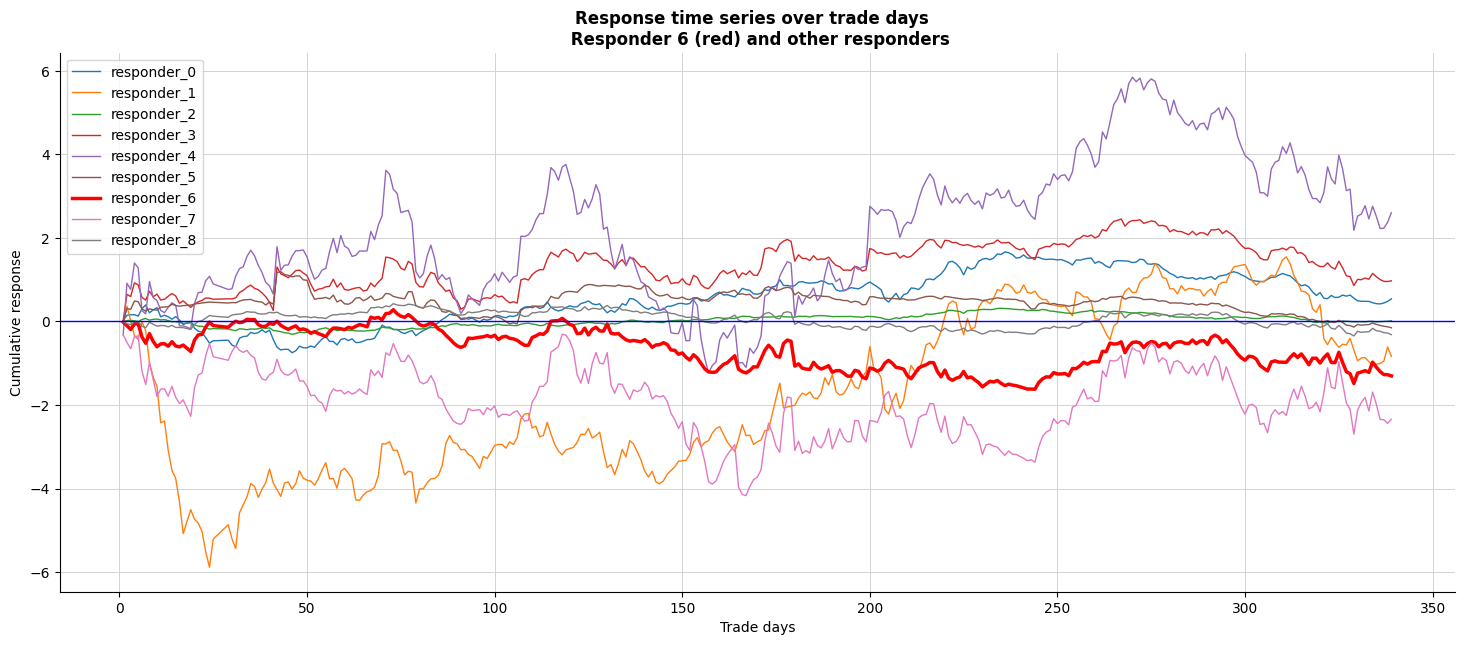

In [7]:
plt.figure(figsize=(18, 7))
predictor_cols = [col for col in sample_df.columns if 'responder' in col]
for i in predictor_cols: 
    if i == 'responder_6': 
        c='red'
        lw=2.5
        plt.plot((sample_df[sample_df.symbol_id == 0].groupby(['date_id'])[i].mean()).cumsum(), linewidth = lw, color = c)
    else: 
        lw=1
        plt.plot((sample_df[sample_df.symbol_id == 0].groupby(['date_id'])[i].mean()).cumsum(), linewidth = lw)

plt.xlabel('Trade days')
plt.ylabel('Cumulative response')
plt.title('Response time series over trade days  \n Responder 6 (red) and other responders', weight='bold')
plt.grid(visible=True, color = gridColor, linewidth = 0.7)
plt.axhline(0, color='blue', linestyle='-', linewidth=1)
plt.legend(predictor_cols)
sns.despine()
#plt.show()

In [ ]:
import pandas as pd
import numpy as np

def subsample_data(file_path: str, n: int = 20):
    """
    Load and subsample the training data.
    """
    # Load the data
    train_df = pd.read_parquet(file_path)
    
    # Subsample
    subsampled_df = train_df.sample(n=n, random_state=42)
    
    # Separate features and response
    features = [col for col in train_df.columns if "feature_" in col]
    response = "responder_6"
    
    return subsampled_df, features, response

# Example usage
subsampled_df, features, response = subsample_data("/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet", n=10000)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

def explore_data(data, features, response):
    """
    Explore the dataset for missing values and autocorrelation.
    """
    print("### Missing Values ###")
    print(data[response].isnull().sum(), "missing in response variable")
    print(data[features].isnull().sum().sum(), "missing in features")
    
    # Plot autocorrelation for the response variable
    plt.figure(figsize=(10, 6))
    autocorrelation_plot(data[response].dropna())
    plt.title("Autocorrelation for Response Variable")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(12, 10))
    corr_matrix = data[features].corr()
    sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
    plt.title("Feature Correlations")
    plt.show()

# Example usage
explore_data(subsampled_df, features, response)


In [ ]:
lags_ : pl.DataFrame | None = None


# Replace this function with your inference code.
# You can return either a Pandas or Polars dataframe, though Polars is recommended.
# Each batch of predictions (except the very first) must be returned within 1 minute of the batch features being provided.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global lags_
    if lags is not None:
        lags_ = lags

    # Replace this section with your own predictions
    predictions = test.select(
        'row_id',
        pl.lit(0.0).alias('responder_6'),
    )

    if isinstance(predictions, pl.DataFrame):
        assert predictions.columns == ['row_id', 'responder_6']
    elif isinstance(predictions, pd.DataFrame):
        assert (predictions.columns == ['row_id', 'responder_6']).all()
    else:
        raise TypeError('The predict function must return a DataFrame')
    # Confirm has as many rows as the test data.
    assert len(predictions) == len(test)

    return predictions

In [ ]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )